# RQ3: Impact of Queries

In [1]:
import os
import pandas as pd
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
)
from itertools import combinations
from sklearn.exceptions import UndefinedMetricWarning
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [2]:
EXPERIMENTS_PATH = "../AutonomicTester/experiment_results"
LABELS = ["similar", "fixed", "buggy"]
RESULTS_FNAME = "results.jsonl"
ANSWER_MAP = {"1": "similar", "2": "fixed", "3": "buggy"}
FORMAL_LABELS = ["already-tested", "need-test", "error-prone"]

In [3]:
def classification(response: str):
    if "1" in response:
        return ANSWER_MAP["1"]
    elif "2" in response:
        return ANSWER_MAP["2"]
    elif "3" in response:
        return ANSWER_MAP["3"]
    else:
        raise ValueError(f"Fail to find valid numbers in {response}!")


def read_results_as_dataframe(experiment_name: str) -> pd.DataFrame:
    target_scenario = experiment_name.split("_")[-1]
    results_path = os.path.join(
        EXPERIMENTS_PATH,
        "queries/Llama3 8B_SingleQuery",
        experiment_name,
        RESULTS_FNAME,
    )
    df = pd.read_json(results_path, lines=True)
    df["target_scenario"] = target_scenario
    df["classified_scenario"] = df["response"].apply(classification)
    return df


def compute_metrics(y_true: list, y_pred: list) -> float:
    precision = precision_score(y_true, y_pred, labels=LABELS, average=None)
    recall = recall_score(y_true, y_pred, labels=LABELS, average=None)
    f1 = f1_score(y_true, y_pred, labels=LABELS, average=None)
    not_yet_tested_f1 = f1[1:].mean()
    avg_f1 = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    avg_precision = precision_score(y_true, y_pred, labels=LABELS, average="macro")
    avg_recall = recall_score(y_true, y_pred, labels=LABELS, average="macro")
    print(
        " | ".join(
            [f"{l}(P R F1)" for l in FORMAL_LABELS]
            + ["not-yet-tested F1", "Total Average F1"]
        )
    )
    print(
        " & ".join(
            [
                " & ".join([f"{precision[i]:.2f}", f"{recall[i]:.2f}", f"{f1[i]:.2f}"])
                for i in range(len(LABELS))
            ]
            + [f"{not_yet_tested_f1:.2f}", f"{avg_f1:.2f}"]
        )
    )
    print(f"avg_precision: {avg_precision:.2f}, avg_recall: {avg_recall:.2f}")
    return avg_f1


def compute_effectiveness(df_exp: pd.DataFrame) -> float:
    y_true = df_exp["target_scenario"].array
    y_pred = df_exp["classified_scenario"].array
    return compute_metrics(y_true, y_pred)


def summarize_metrics(model_experiments_path: str) -> float:
    """
    Summarize metrics about effectiveness for a specific LLM and dataset.

    Parameters
    ----------
    model_experiments_path: str
       path to the experiments for a specific LLM
    """
    y_true = []
    y_pred = []
    for experiment in os.listdir(model_experiments_path):
        experiment_path = os.path.join(model_experiments_path, experiment)
        # Skip not directories
        if not os.path.isdir(experiment_path):
            continue
        true_scenario = experiment.split("_")[-1]
        # Read statistics
        df_votes = pd.read_csv(os.path.join(experiment_path, "scenario_votes.csv"))
        df_votes["truth"] = true_scenario
        y_pred += df_votes["scenario"].to_list()
        y_true += df_votes["truth"].to_list()
    return compute_metrics(y_true, y_pred)

In [4]:
f1_queries = {}

In [5]:
def evaluate_single_query() -> float:
    buggy_exp = "20250122_140855_Meta LLama3 8B_Defects4J_buggy"
    fixed_exp = "20250122_151802_Meta LLama3 8B_Defects4J_fixed"
    similar_exp = "20250122_174029_Meta LLama3 8B_Defects4J_similar"
    df_buggy = read_results_as_dataframe(buggy_exp)
    df_fixed = read_results_as_dataframe(fixed_exp)
    df_similar = read_results_as_dataframe(similar_exp)
    df_exp = pd.concat([df_buggy, df_fixed, df_similar])
    return compute_effectiveness(df_exp)

In [6]:
f1_queries["Single Query"] = evaluate_single_query()

already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.19 & 0.06 & 0.09 & 0.39 & 0.74 & 0.51 & 0.27 & 0.16 & 0.20 & 0.36 & 0.27
avg_precision: 0.28, avg_recall: 0.32


In [7]:
def evaluate_triple_queries():
    comb_3_queries = combinations(["Q1", "Q2", "Q3", "Q4", "Q5"], 3)
    for comb in comb_3_queries:
        selected_queries = "".join(comb)
        print(" ".join(comb))
        model_experiments_path = os.path.join(
            EXPERIMENTS_PATH,
            "queries/FineTunedGPT3.5Turbo_3queries",
            selected_queries,
        )
        query_set_name = "-".join(comb).replace("Q", "")
        f1_queries[query_set_name] = summarize_metrics(model_experiments_path)

In [8]:
evaluate_triple_queries()

Q1 Q2 Q3
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.68 & 0.93 & 0.79 & 0.50 & 0.00 & 0.00 & 0.49 & 0.84 & 0.62 & 0.31 & 0.47
avg_precision: 0.56, avg_recall: 0.59
Q1 Q2 Q4
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.69 & 0.93 & 0.79 & 0.00 & 0.00 & 0.00 & 0.48 & 0.84 & 0.62 & 0.31 & 0.47
avg_precision: 0.39, avg_recall: 0.59
Q1 Q2 Q5
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.69 & 0.93 & 0.79 & 0.00 & 0.00 & 0.00 & 0.48 & 0.84 & 0.61 & 0.31 & 0.47
avg_precision: 0.39, avg_recall: 0.59
Q1 Q3 Q4
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | Total Average F1
0.00 & 0.00 & 0.00 & 0.48 & 0.85 & 0.61 & 0.15 & 0.15 & 0.15 & 0.38 & 0.25
avg_precision: 0.21, avg_recall: 0.33
Q1 Q3 Q5
already-tested(P R F1) | need-test(P R F1) | error-prone(P R F1) | not-yet-tested F1 | 

In [9]:
f1_queries["1-2-3-4-5"] = 0.54

In [10]:
def draw_barplot(query_combinations):
    if not os.path.exists("images"):
        os.mkdir("images")
    # plt.rcParams.update({"text.usetex": True, "font.family": "Times New Roman"})
    # Sort the query combinations in descending order by F1-score.
    # (Since 1-2-3-4-5 has the highest score, it will appear first.)
    sorted_data = sorted(query_combinations.items(), key=lambda x: x[1], reverse=True)
    queries = [item[0] for item in sorted_data]
    f1_scores = [item[1] for item in sorted_data]

    # Font size for labels
    fontsize_paper = 26

    # X positions for the bars
    x = np.arange(len(queries))

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bars
    bars = ax.bar(x, f1_scores, color="#0072B2", edgecolor="black", width=0.6)

    # Configure the x-axis with query combination labels
    ax.set_xticks(x)
    ax.set_xticklabels(queries, rotation=30, ha="right", fontsize=fontsize_paper)

    # Set y-axis label and limits (F1-scores are between 0 and 1; here we set 0 to 0.6 for clarity)
    ax.set_ylabel("F1-score", fontsize=fontsize_paper)
    ax.set_ylim(0, 0.6)
    ax.tick_params(axis="y", labelsize=fontsize_paper)

    # Annotate each bar with its F1-score value
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=fontsize_paper,
        )

    plt.tight_layout()
    plt.savefig("images/RQ3_barplot.pdf", format="pdf", bbox_inches="tight")

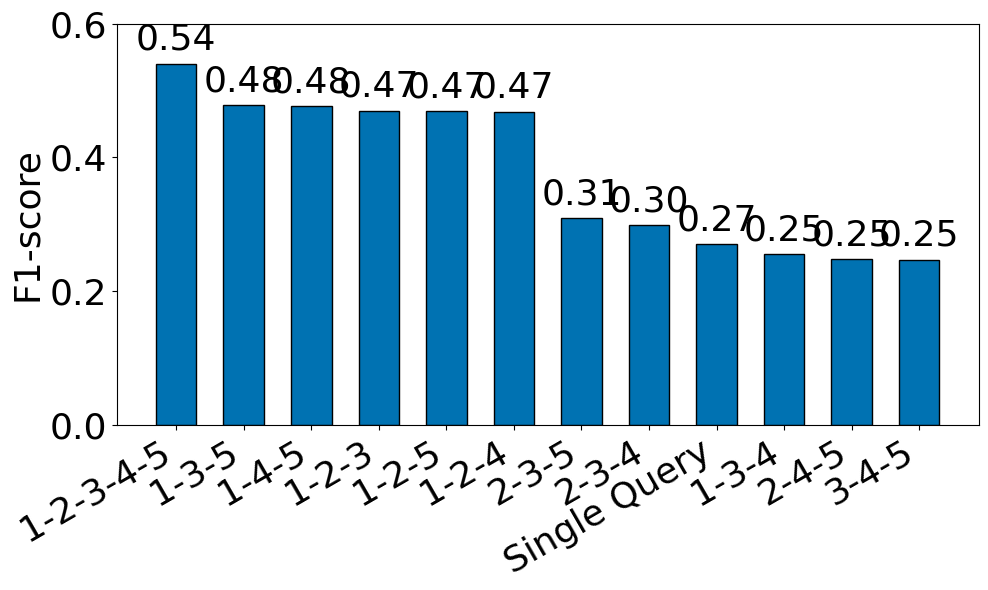

In [11]:
draw_barplot(f1_queries)